## Neural Network Image Classification

### Import Data

In [ ]:
!pwd
!mkdir /content/kaggle/
!mkdir /content/kaggle/
!pip install -q kaggle

/content
mkdir: cannot create directory ‘/content/kaggle/’: File exists


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yumidata","key":"f5a913787df7b99e918be4868b26650d"}'}

In [ ]:
!mkdir /root/.kaggle/

In [ ]:
!mv kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content/kaggle/

100% 813M/814M [00:38<00:00, 23.4MB/s]
100% 814M/814M [00:38<00:00, 22.1MB/s]


In [ ]:
!unzip -o /content/kaggle/dogs-vs-cats-redux-kernels-edition.zip -d /content/kaggle/

Archive:  /content/kaggle/dogs-vs-cats-redux-kernels-edition.zip
  inflating: /content/kaggle/sample_submission.csv  
  inflating: /content/kaggle/test.zip  
  inflating: /content/kaggle/train.zip  


In [ ]:
!ls /content/kaggle/


dogs-vs-cats-redux-kernels-edition.zip	sample_submission.csv  test.zip  train.zip


In [ ]:
!unzip -o /content/kaggle/train.zip -d /content/kaggle/

In [ ]:
!unzip -o /content/kaggle/test.zip -d /content/kaggle/

### Load Package

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os, cv2, random # os- path handling; cv2- image processing
import zipfile
import glob
from tqdm import tqdm

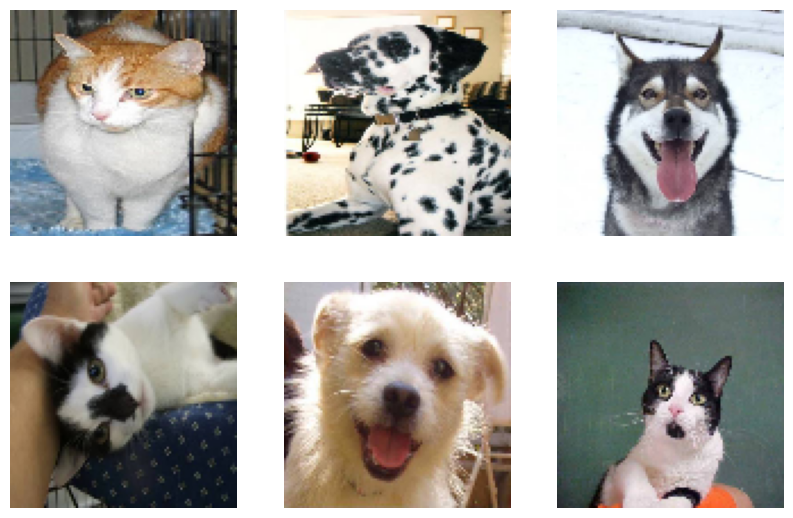

In [ ]:
# Check the input of the data
PATH = '/content/kaggle/train'
filename = os.listdir(PATH)
IMG_SIZE = 100 # define ourselve to resize the image size

plt.figure(figsize=(10,10))
for i in range(1, 7):
    img_array = cv2.imread(os.path.join(PATH, filename[i]))
    resize_image = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.subplot(3,3, i)
    image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB)
    #plt.figure()
    plt.axis('off')
    plt.imshow(image)

In [ ]:
ss = pd.read_csv('/content/kaggle/sample_submission.csv')
ss.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


### Change the Data Format

In [ ]:
# Train Data
# based on filename and assign a category
# reads the image in grayscale, resizes it

def process_image(img_name, img_size, path):
    try:
        category = 0 if img_name.find('cat') == -1 else 1
        img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (img_size, img_size))
        return [new_array, category]
    except Exception as e:
        return None

IMG_SIZE = 100
path = '/content/kaggle/train'
filenames = os.listdir(path)

# Using list comprehension to process images
training_data = [process_image(img, IMG_SIZE, path) for img in tqdm(filenames)]
training_data = [item for item in training_data if item is not None]

100%|██████████| 25000/25000 [00:21<00:00, 1153.27it/s]


In [ ]:
# Test Data
def process_test_image(img_name, img_size, path):
    try:
        img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (img_size, img_size))
        return [new_array]
    except Exception as e:
        return None

IMG_SIZE = 100
path = '/content/kaggle/test'
filenames = os.listdir(path)

# Using list comprehension to process images
testing_data = [process_test_image(img, IMG_SIZE, path) for img in tqdm(filenames)]
testing_data = [item for item in testing_data if item is not None]

100%|██████████| 12500/12500 [00:10<00:00, 1179.94it/s]


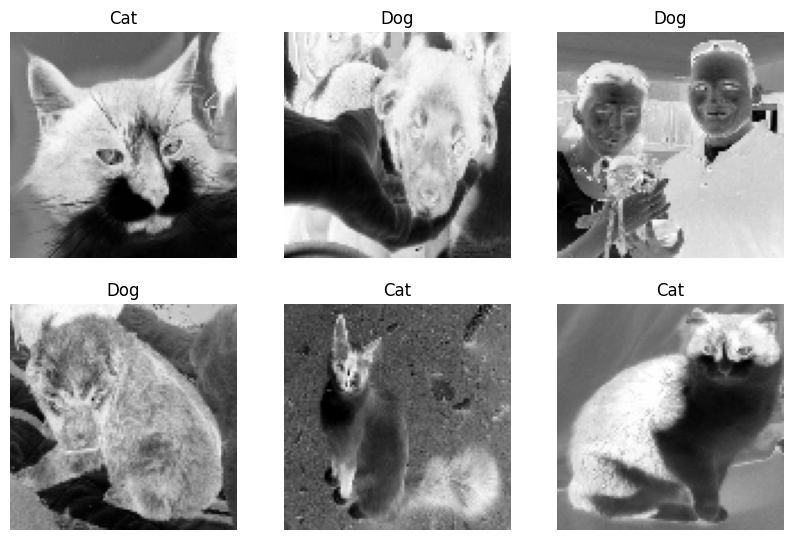

In [ ]:
# Check the filename category
plt.figure(figsize=(10,10))
for i in range(1, 7):
    plt.subplot(3,3,i)
    plt.axis('off')
    if training_data[10+i][1] == 0:
        plt.title('Dog')
    else:
        plt.title('Cat')
    plt.imshow(training_data[10+i][0], cmap='gray_r')

In [ ]:
random.shuffle(training_data)

In [ ]:
# Build the Training Data Set
X = []
y = []

for features, label  in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
# Normalize
X = X/255.0

X = np.array(X)
y = np.array(y)

### Train and Test Split Data

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### CNN Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, LeakyReLU, MaxPooling2D, BatchNormalization, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input


In [ ]:
model = Sequential()

model.add(Conv2D(96, (3,3), input_shape=X_train.shape[1:]))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3)))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.5))  # Adding Dropout to prevent overfitting

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

history = model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
79/79 [==============================] - 28s 195ms/step - loss: 0.7714 - accuracy: 0.5487 - val_loss: 0.6858 - val_accuracy: 0.5758
Epoch 2/10
79/79 [==============================] - 14s 176ms/step - loss: 0.6494 - accuracy: 0.6120 - val_loss: 0.6780 - val_accuracy: 0.5980
Epoch 3/10
79/79 [==============================] - 14s 177ms/step - loss: 0.6074 - accuracy: 0.6674 - val_loss: 0.6344 - val_accuracy: 0.6312
Epoch 4/10
79/79 [==============================] - 14s 178ms/step - loss: 0.5791 - accuracy: 0.7003 - val_loss: 0.6495 - val_accuracy: 0.6128
Epoch 5/10
79/79 [==============================] - 14s 178ms/step - loss: 0.5426 - accuracy: 0.7272 - val_loss: 0.6879 - val_accuracy: 0.6250
Epoch 6/10
79/79 [==============================] - 14s 178ms/step - loss: 0.5126 - accuracy: 0.7524 - val_loss: 0.7559 - val_accuracy: 0.6054
Epoch 7/10
79/79 [==============================] - 14s 179ms/step - loss: 0.4822 - accuracy: 0.7685 - val_loss: 0.5487 - val_accuracy: 0.7330

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.45384350419044495
Test accuracy: 0.7972000241279602


### Plot the Result

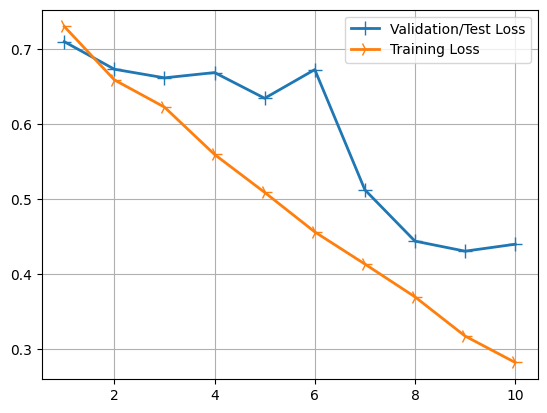

In [ ]:
# Loss Charts
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

line1 = plt.plot(epochs, val_loss_values, label ='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth = 2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
IMG_SIZE = 100
test = []

for features  in testing_data:
    test.append(features)

test = np.array(test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
test = test/255.0
test = np.array(test)
prediction = model.predict(test)

#### Export the Outcome

In [ ]:
MSBA_Session1_YumiYu = pd.read_csv('/content/kaggle/sample_submission.csv')
MSBA_Session1_YumiYu['label'] = prediction

In [ ]:
MSBA_Session1_YumiYu.to_csv('/content/kaggle/MSBA_Session1_YumiYu_6.csv', index=False)